In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

<Axes: >

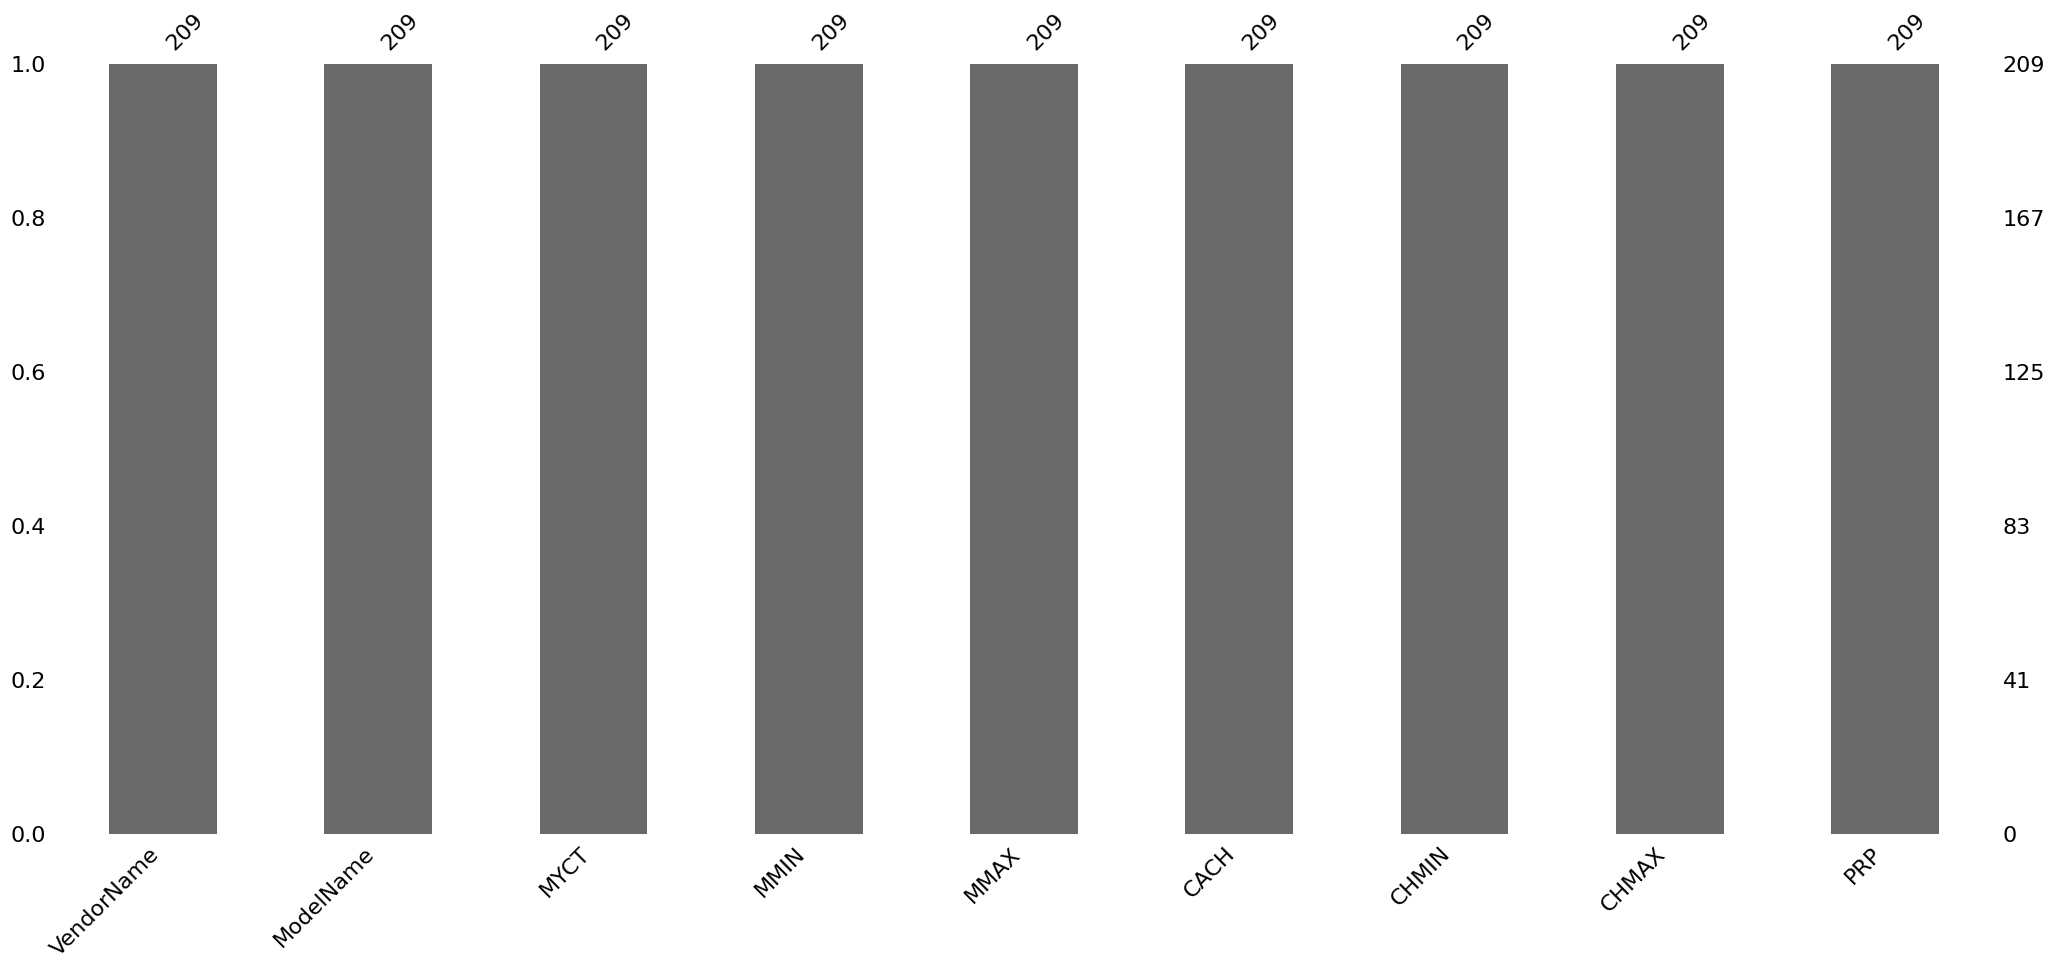

In [22]:
## csv로 저장되어 있는 값을 pandas의 DataFrame 값으로 변환 하기
machine = pd.read_csv("machine_data.csv")
## 컬럼이 무엇이 있는지 확인
machine.columns
import missingno as msn
# 결측값의 개수를 막대 그래프로 시각화 한다.
msn.bar(machine)

In [23]:
# 정확성을 위해서 결측치의 값을 제거해 준다
# 결측치가 하나도 없는 것을 알 수 있다.
machine.dropna(inplace = True)
#결측치가 없는 것을 확인했기 때문에 PRP와의 상관 관계를 계산해서 변수를 선택해줘야한다.
# pandas 라이브러리에 포함된 DataFrame의 메서드인 corr() 메서드를 사용해야 한다.
# 또한 상관도를 구할 때 모든 변수들의 값은 수치화 되어야 한다.
# 모든 변수를 수치화 한다.
dums = pd.get_dummies(machine, dtype=float)
# PRP와의 상관계수 계산
prp_resulte = dums.corr()['PRP']
# 상관계수 값을 절대값으로 변환
# 변환의 이유는 간단하다. corr() 메서드가 -1~1의 값을 가져오기 때문이다.
prp_resulte= np.abs(prp_resulte)

In [24]:
# 상관계수를 내림차순으로 정렬
prp_resulte.sort_values(ascending=False)
# 내림차순으로 선택 후 상관 관계가 높은 features 선택
num_features = prp_resulte.sort_values(ascending=False).index[1:6].tolist()
X_train = dums[num_features]
X_test = dums[num_features]
y_train = dums['PRP']
y_test = dums['PRP']

In [25]:
# 앙상블 기법으로 모델 생성 및 학습  : LinearRegression, SGDRegressor, Ridge, GradientBoostingRegressor
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])
# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]
# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('ensemble', ensemble)])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha": [0.0001, 0.1, 1.0],
    "ensemble__sgd__max_iter": [1000, 2000, 3000],
    "ensemble__ridge__alpha": [10, 20],
    "ensemble__gbr__n_estimators": [100, 200],
    "ensemble__gbr__learning_rate": [0.01, 0.1]
}
grid_search = GridSearchCV(model_pipeline, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MMAX',
                                                                          'MMIN',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor()),
                                                                    ('ridge',
                                                                     Ridge(random_state=42)),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             param_grid={'ensemble__gbr__learning_rate': [0.01, 0.1],
                         'ensemble__gbr__n_estimators': [100, 200],
                         'ensemble__ridge__alpha': [10, 20],
                         'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

Mean Squared Error: 2156.065952853968
Mean Absolute Error: 29.57835643400506
R^2 Score: 0.916245739262959


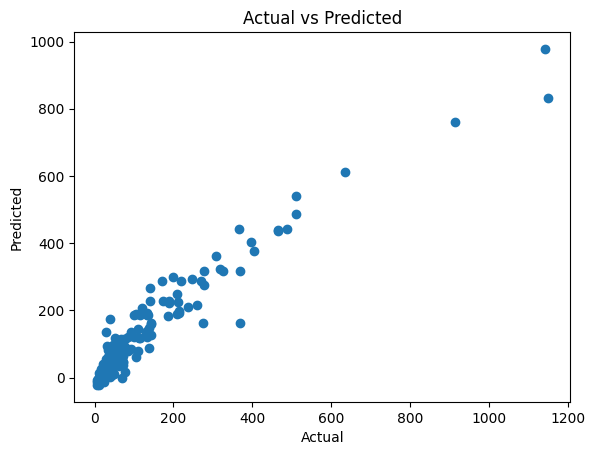

In [26]:
# 최적 파라미터를 이용하여 최적 모델로 예측하기
# 1) 최적 파라미터 출력
# print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 2) 최적 모델 출력
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# 최적 모델 성능 평가 및 시각화
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [27]:
# GridSearchCV 결과 분석
result = pd.DataFrame(grid_search.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ensemble__gbr__learning_rate,param_ensemble__gbr__n_estimators,param_ensemble__ridge__alpha,param_ensemble__sgd__alpha,param_ensemble__sgd__max_iter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.043210,0.001327,0.002600,4.900768e-04,0.01,100,10,0.0001,1000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6500.430325,7579.214314,64,-2295.822372,-3355.299368,-3428.348915,-3226.218705,-1706.487220,-2802.435316,683.341460
1,0.041809,0.001470,0.002001,1.784161e-07,0.01,100,10,0.0001,2000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6500.761589,7591.303422,65,-2276.717981,-3340.130224,-3415.823825,-3226.203229,-1712.902203,-2794.355493,679.422582
2,0.041209,0.001939,0.002401,4.900182e-04,0.01,100,10,0.0001,3000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6517.109555,7609.739241,66,-2288.911299,-3342.104050,-3430.507852,-3241.880574,-1716.083639,-2803.897483,681.569627
3,0.042010,0.001674,0.002800,7.484558e-04,0.01,100,10,0.1,1000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6489.211702,7576.888310,59,-2343.933126,-3393.110605,-3469.809904,-3292.041840,-1739.717501,-2847.722595,687.508460
4,0.046211,0.002316,0.002600,4.897654e-04,0.01,100,10,0.1,2000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6497.800078,7623.989371,62,-2325.975494,-3398.572367,-3494.754533,-3285.773825,-1758.548297,-2852.724903,688.820768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.077817,0.002926,0.002601,4.901545e-04,0.1,200,20,0.1,2000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5729.019266,6531.162503,2,-1644.267349,-2415.472000,-2486.239169,-2330.398992,-1194.838834,-2014.243269,508.335494
68,0.084219,0.003311,0.002801,4.001856e-04,0.1,200,20,0.1,3000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5734.594245,6538.898402,3,-1642.003459,-2411.958886,-2484.894964,-2328.010126,-1195.130267,-2012.399541,507.470583
69,0.077817,0.002639,0.002400,4.899015e-04,0.1,200,20,1.0,1000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5752.856857,6673.270018,11,-1770.693685,-2597.033006,-2672.880678,-2465.516002,-1291.660198,-2159.556714,539.065284
70,0.076817,0.001939,0.003001,1.095627e-03,0.1,200,20,1.0,2000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5753.172725,6700.532978,12,-1751.115379,-2590.493008,-2675.694810,-2485.586760,-1299.412040,-2160.460399,541.307550
